In [1]:
import os
import gc
import cv2
import time
import itertools
import sklearn

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

from keras import backend as K
from matplotlib import pyplot as plt

from glob import glob
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras import models
from keras_preprocessing.image import ImageDataGenerator

from keras.layers import Input
from keras.models import Sequential, Model
from keras.layers.core import Dense
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Activation
from keras import regularizers, applications, optimizers, initializers
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.applications import EfficientNetB7

In [2]:
def calculate_cm(y_true, y_pred):
    fp = np.sum((y_pred == 1) & (y_true == 0))
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    return tp, fp, fn, tn

def calculate_recall(tp, fp, fn, tn):
    return (tp)/(tp + fn)

def calculate_fallout(tp, fp, fn, tn):
    return (fp)/(fp + tn)

def calculate_fpr_tpr(y_true, y_pred):
    tp, fp, fn, tn = calculate_cm(y_true, y_pred)
    tpr = calculate_recall(tp, fp, fn, tn)
    fpr = calculate_fallout(tp, fp, fn, tn)
    return fpr, tpr

In [3]:
image_paths = {os.path.basename(x): x for x in glob(os.path.join('.', 'images', '*.png'))}
df = pd.read_csv("./dataset_information/Data_Entry_2017.csv")

df = df.drop(
    columns = [
        "Follow-up #", 
        "Patient ID", 
        "Patient Age", 
        "Patient Gender", 
        "OriginalImage[Width",
        "Height]",
        "OriginalImagePixelSpacing[x",
        "y]",
#         "Unnamed: 11",
        "View Position"
    ], 
    axis = 1
)

df["Image Paths"] = " "
for row_index in tqdm(range(len(df)), ncols = 100):
    img_name = df.iloc[row_index][0]
    path = image_paths[img_name]
    df["Image Paths"][row_index] = path

unique_labels = set(itertools.chain.from_iterable(df["Finding Labels"].apply(lambda x : x.split('|')).values)) 
one_hot_labels = pd.DataFrame(0.0, index = np.arange(len(df)), columns = unique_labels)

for index, row in df.iterrows():
    labels = row["Finding Labels"].split('|')
    for label in labels:
        one_hot_labels.iloc[index][label] = 1.0

df = pd.concat([df, one_hot_labels], axis = 1)
df = df.drop(columns = ["Finding Labels"], axis = 1)
df.head()

100%|█████████████████████████████████████████████████████| 112120/112120 [01:31<00:00, 1221.12it/s]


,Image Index,Image Paths,Infiltration,Emphysema,Hernia,Effusion,Nodule,Mass,Cardiomegaly,No Finding,Fibrosis,Edema,Pneumonia,Atelectasis,Pneumothorax,Consolidation,Pleural_Thickening
0,00000001_000.png,.\images\00000001_000.png,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,.\images\00000001_001.png,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,.\images\00000001_002.png,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,.\images\00000002_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,.\images\00000003_000.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# df_train, df_test = train_test_split(dataset_info.sample(n = 60000), test_size = 0.20, random_state = 142)
df_train, df_test = train_test_split(df, test_size = 0.20, random_state = 0)
df_train, df_val = train_test_split(df_train, test_size = 0.10, random_state = 0)

print(f"Training Samples: {len(df_train)}\nValidation Samples: {len(df_val)}\nTesting Samples: {len(df_test)}")

Training Samples: 80726
Validation Samples: 8970
Testing Samples: 22424


In [5]:
CLASS_LABELS = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", 
    "Infiltration", "Mass", "No Finding", "Nodule", "Pleural_Thickening", "Pneumonia","Pneumothorax"
]
IMAGE_SIZE = (224, 224,)
BATCH_SIZE = 24
EPOCHS = 15

BETA_FOR_BIASED_RECALL = 1.3
BETA_FOR_BIASED_PRECISION = 0.7
BETA_WITH_NO_BIAS = 1

THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

METRICS = [
  tf.keras.metrics.TruePositives(name = 'tp'),
  tf.keras.metrics.FalsePositives(name = 'fp'),
  tf.keras.metrics.TrueNegatives(name = 'tn'),
  tf.keras.metrics.FalseNegatives(name = 'fn'), 
  tf.keras.metrics.BinaryAccuracy(name = 'binary_accuracy'),
  tf.keras.metrics.Precision(name = 'precision', thresholds = 0.3),
  tf.keras.metrics.Recall(name = 'recall', thresholds = 0.3),
  tf.keras.metrics.AUC(name = 'auc', multi_label = True, num_labels = 15, thresholds = THRESHOLDS),
  tf.keras.metrics.AUC(name = 'prc', curve = 'PR')
]

In [6]:
def flow_from_dataframe(image_generator, dataframe):
    df_gen = image_generator.flow_from_dataframe(
        dataframe,
        x_col = "Image Paths", 
        y_col = dataframe.columns[2:],
        target_size = IMAGE_SIZE,
        color_mode = 'rgb',
        class_mode = 'raw',
        shuffle = False,
        batch_size = BATCH_SIZE
    )
    return df_gen

def sharpen_image(image):
    sharp_kernel = np.array(
        [
            [0, -1, 0], 
            [-1, 5, -1], 
            [0, -1, 0]
        ])
    output = cv2.filter2D(src = image, ddepth = -1, kernel = sharp_kernel)
    return output

In [7]:
train_data_generator = ImageDataGenerator(
    rescale = 1. / 255,
    preprocessing_function = sharpen_image,
    zca_whitening = False,
    rotation_range = 20,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True
)
val_data_generator = ImageDataGenerator(
    rescale = 1. / 255,
    preprocessing_function = sharpen_image
)
test_data_generator = ImageDataGenerator(
    rescale = 1. / 255,
    preprocessing_function = sharpen_image
)

In [8]:
train_gen = flow_from_dataframe(image_generator = train_data_generator, dataframe = df_train)
valid_gen = flow_from_dataframe(image_generator = val_data_generator, dataframe = df_val)
test_gen = flow_from_dataframe(image_generator = test_data_generator, dataframe = df_test)

Found 80726 validated image filenames.
Found 8970 validated image filenames.
Found 22424 validated image filenames.


In [9]:
SGD_optimizer = tf.keras.optimizers.SGD(
    learning_rate = 0.0001, 
    decay = 1e-6, 
    momentum = 0.9, 
    nesterov = True
)
adam_optimizer = tf.keras.optimizers.Adam(
    learning_rate = 0.0001,
    beta_1 = 0.9,
    beta_2 = 0.999,
)

In [10]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 4,
    verbose = 1,
    mode = 'auto',
    baseline = None,
    restore_best_weights = True
)

In [36]:
channels = (3,)
input_shape = IMAGE_SIZE + channels
img_input = Input(shape = input_shape)

MODEL_NAME = "ResNet50V2"
base_model = ResNet50V2(
    input_shape = input_shape,
    include_top = False,
    weights = "imagenet"
)

custom_classifier = Sequential()
custom_classifier.add(GlobalAveragePooling2D(input_shape = base_model.output_shape[1:]))
custom_classifier.add(Dropout(0.2))

custom_classifier.add(Dense(256))
custom_classifier.add(BatchNormalization())
custom_classifier.add(Activation('relu'))
custom_classifier.add(Dropout(0.2))

custom_classifier.add(Dense(50))
custom_classifier.add(BatchNormalization())
custom_classifier.add(Activation('relu'))
custom_classifier.add(Dropout(0.2))

custom_classifier.add(Dense(15, activation = "sigmoid"))

model = Model(inputs = base_model.input, outputs = custom_classifier(base_model.output))
# model.load_weights(f"./saved_weights/{MODEL_NAME}_{EPOCHS}_weights.h5")

model.compile(
    optimizer = adam_optimizer,
    loss = "binary_crossentropy",
    metrics = METRICS
)

In [ ]:
start_time = time.time()

history = model.fit_generator(
    epochs = EPOCHS,
    generator = train_gen,
    steps_per_epoch = train_gen.n / train_gen.batch_size,
    validation_data = valid_gen,
    validation_steps = valid_gen.n / valid_gen.batch_size,
    shuffle = False,
    verbose = 1,
    callbacks = None
)

print(f"\nTime Taken: {(time.time() - start_time) / 3600 : .4f} Hours")

C:\Users\m7irt\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
3363/3363 [==============================] - 2993s 887ms/step - loss: 0.2303 - tp: 41364.0000 - fp: 28389.0000 - tn: 1388838.0000 - fn: 88659.0000 - binary_accuracy: 0.9243 - precision: 0.4175 - recall: 0.4975 - auc: 0.5887 - prc: 0.4307 - val_loss: 0.1955 - val_tp: 3615.0000 - val_fp: 1576.0000 - val_tn: 121597.0000 - val_fn: 7762.0000 - val_binary_accuracy: 0.9306 - val_precision: 0.5511 - val_recall: 0.4773 - val_auc: 0.5821 - val_prc: 0.5171
Epoch 2/15
3363/3363 [==============================] - 2907s 864ms/step - loss: 0.1991 - tp: 33039.0000 - fp: 15016.0000 - tn: 1094159.0000 - fn: 68676.0000 - binary_accuracy: 0.9309 - precision: 0.5262 - recall: 0.4899 - auc: 0.5995 - prc: 0.5027 - val_loss: 0.1933 - val_tp: 3522.0000 - val_fp: 1372.0000 - val_tn: 121801.0000 - val_fn: 7855.0000 - val_binary_accuracy: 0.9314 - val_precision: 0.5298 - val_recall: 0.5073 - val_auc: 0.6284 - val_prc: 0.5261
Epoch 3/15
3363/3363 [==============================] - 2786s 828ms/step - los

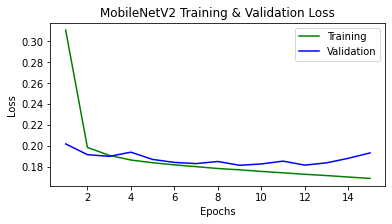

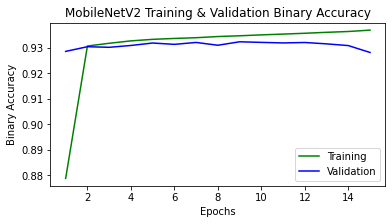

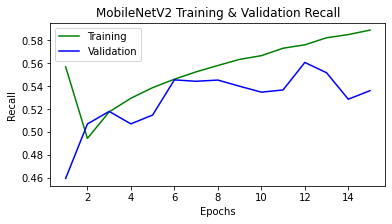

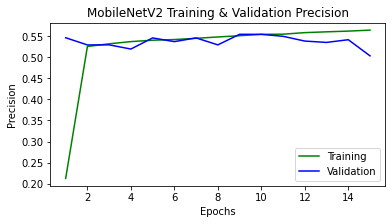

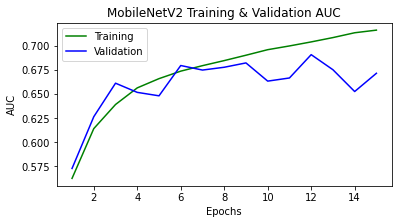

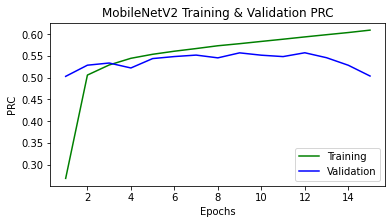

In [13]:
plt.figure(1, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['loss'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_loss'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(2, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['binary_accuracy'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_binary_accuracy'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Binary Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.show()

plt.figure(3, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['recall'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_recall'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.figure(4, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['precision'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_precision'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

plt.figure(6, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['auc'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_auc'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

plt.figure(7, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['prc'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_prc'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation PRC')
plt.xlabel('Epochs')
plt.ylabel('PRC')
plt.legend()
plt.show()

In [14]:
model.save_weights(f"./saved_weights/{MODEL_NAME}_{EPOCHS}_weights.h5")
evaluation = model.evaluate(test_gen)

935/935 [==============================] - 390s 417ms/step - loss: 0.1914 - tp: 10200.0000 - fp: 5483.0000 - tn: 302569.0000 - fn: 18108.0000 - binary_accuracy: 0.9299 - precision: 0.5092 - recall: 0.5413 - auc: 0.6702 - prc: 0.5146


In [15]:
test_loss = evaluation[0]
TP = evaluation[1]
FP = evaluation[2]
TN = evaluation[3]
FN = evaluation[4]
binary_accuracy = evaluation[5] * 100
auc = evaluation[8] * 100
auc_pr = evaluation[9] * 100

specificity = (TN / (TN + FP)) * 100
recall = (TP / (TP + FN)) * 100
precision = (TP / (TP + FP)) * 100
f1_score = (2 * recall * precision) / (recall + precision)

print(f"Testing Loss: \t\t{test_loss}\n")
print(f"True Positives: \t{TP}\nFalse Positives: \t{FP}\nTrue Negatives: \t{TN}\nFalse Negatives: \t{FN}\n")
print(f"Binary Accuracy: \t{binary_accuracy}")
print(f"Average Recall: \t{recall}\nAverage Precision: \t{precision}\nF1-Score: \t\t{f1_score}\nAverage Specificity: \t{specificity}\n")
print(f"AUC: \t\t\t{auc}\nAUC-PR: \t\t{auc_pr}")

Testing Loss: 		0.19142131507396698

True Positives: 	10200.0
False Positives: 	5483.0
True Negatives: 	302569.0
False Negatives: 	18108.0

Binary Accuracy: 	92.98646450042725
Average Recall: 	36.03221704111912
Average Precision: 	65.03857680290761
F1-Score: 		46.373121774908505
Average Specificity: 	98.22010569644087

AUC: 			67.0185387134552
AUC-PR: 		51.45648717880249


In [16]:
test_gen.reset()
predictions = model.predict(test_gen)

In [17]:
def binary_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

def precision_threshold(threshold = 0.5):
    def precision(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(y_pred)
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision

def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall

def fbeta_score_threshold(beta = 1, threshold = 0.5):
    def fbeta_score(y_true, y_pred):
        threshold_value = threshold
        beta_value = beta
        p = precision_threshold(threshold_value)(y_true, y_pred)
        r = recall_threshold(threshold_value)(y_true, y_pred)
        bb = beta_value ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score
    return fbeta_score
    
def print_results(beta, threshold, test_labels, prediction):
    accuracy = K.eval(binary_accuracy(K.variable(value = test_labels), K.variable(value = prediction)))
    precision = K.eval(precision_threshold(threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    recall = K.eval(recall_threshold(threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    f1_score = K.eval(fbeta_score_threshold(beta = beta, threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    print(f"BETA: {beta}, THRESHOLD: {threshold}")
    print (f"Binary Accuracy: \t{accuracy * 100} % \nRecall: \t\t{recall * 100} % \nPrecision: \t\t{precision * 100} % \nF1-Score: \t\t{f1_score * 100} %\n")

In [18]:
test_labels = []
for label in test_gen.labels:
    test_labels.append(label)

# # Results with F Score giving more weightage to Recall
# for threshold in THRESHOLDS:
#     print_results(beta = BETA_FOR_BIASED_RECALL, threshold = threshold, test_labels = test_labels, prediction = predictions)

# # Results with F Score giving more weightage to Precision
# for threshold in THRESHOLDS:
#     print_results(beta = BETA_FOR_BIASED_PRECISION, threshold = threshold, test_labels = test_labels, prediction = predictions)

# Results with F Score giving equal weightage to Recall and Precision
for threshold in THRESHOLDS:
    print_results(beta = BETA_WITH_NO_BIAS, threshold = threshold, test_labels = test_labels, prediction = predictions)

BETA: 1, THRESHOLD: 0.1
Binary Accuracy: 	92.98638105392456 % 
Recall: 		77.5293231010437 % 
Precision: 		30.9999018907547 % 
F1-Score: 		44.29039657115936 %

BETA: 1, THRESHOLD: 0.2
Binary Accuracy: 	92.98638105392456 % 
Recall: 		64.22212719917297 % 
Precision: 		41.80175065994263 % 
F1-Score: 		50.641363859176636 %

BETA: 1, THRESHOLD: 0.3
Binary Accuracy: 	92.98638105392456 % 
Recall: 		54.12604212760925 % 
Precision: 		50.91549754142761 % 
F1-Score: 		52.47170329093933 %

BETA: 1, THRESHOLD: 0.4
Binary Accuracy: 	92.98638105392456 % 
Recall: 		45.26282250881195 % 
Precision: 		58.124661445617676 % 
F1-Score: 		50.89370012283325 %

BETA: 1, THRESHOLD: 0.5
Binary Accuracy: 	92.98638105392456 % 
Recall: 		36.03221774101257 % 
Precision: 		65.03857970237732 % 
F1-Score: 		46.373119950294495 %

BETA: 1, THRESHOLD: 0.6
Binary Accuracy: 	92.98638105392456 % 
Recall: 		24.742121994495392 % 
Precision: 		70.98408937454224 % 
F1-Score: 		36.69416904449463 %

BETA: 1, THRESHOLD: 0.7
Binary A

In [19]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names,)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix - " + class_label)

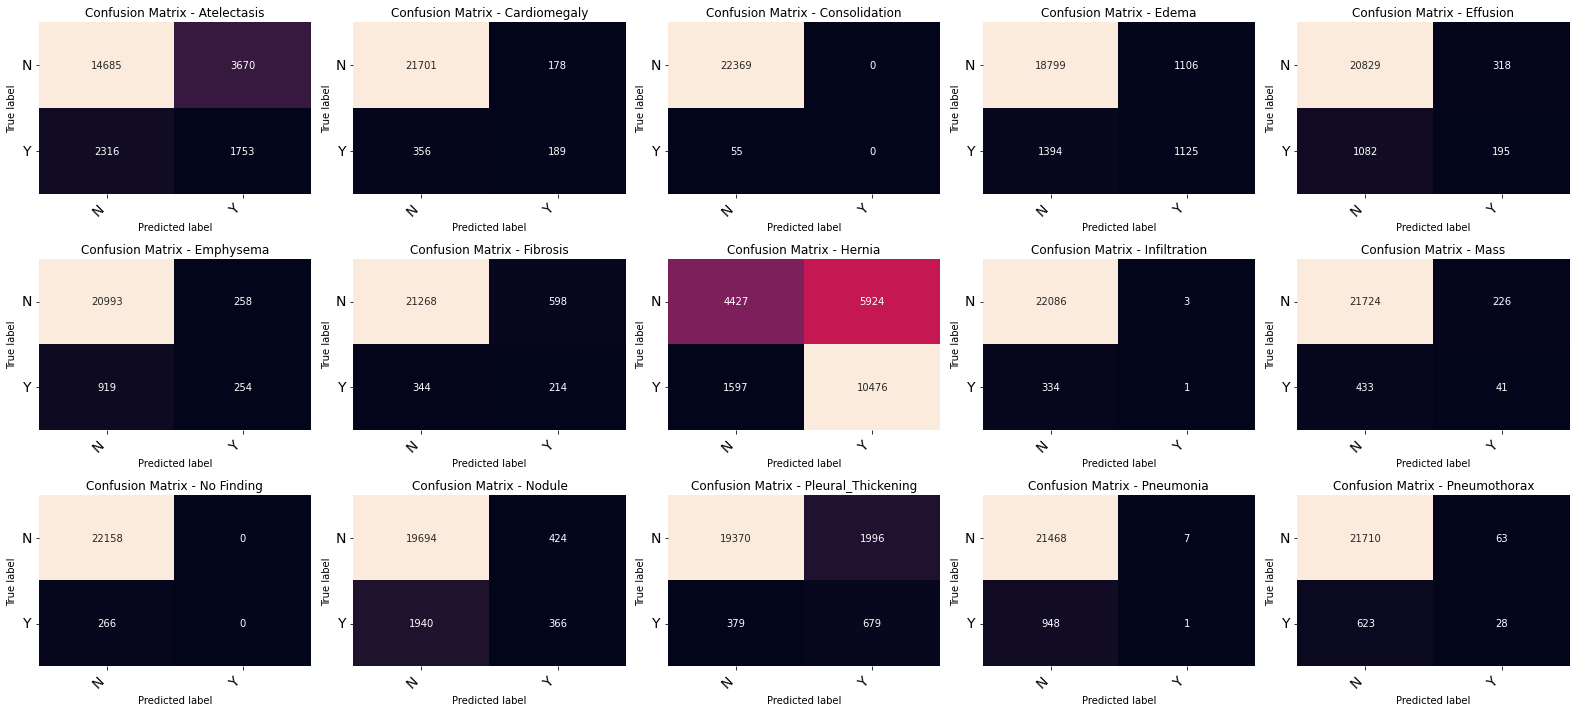

In [20]:
threshold = 0.3
y_test = test_gen.labels
y_predicted = (predictions >= threshold).astype(int)
confusion_matrix = multilabel_confusion_matrix(y_test, y_predicted)

fig, ax = plt.subplots(3, 5, figsize=(22, 10))
for axes, cfs_matrix, label in zip(ax.flatten(), confusion_matrix, CLASS_LABELS):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

[MobileNetV2 with 15 Epochs] - Average AUC: 0.7784512884725044


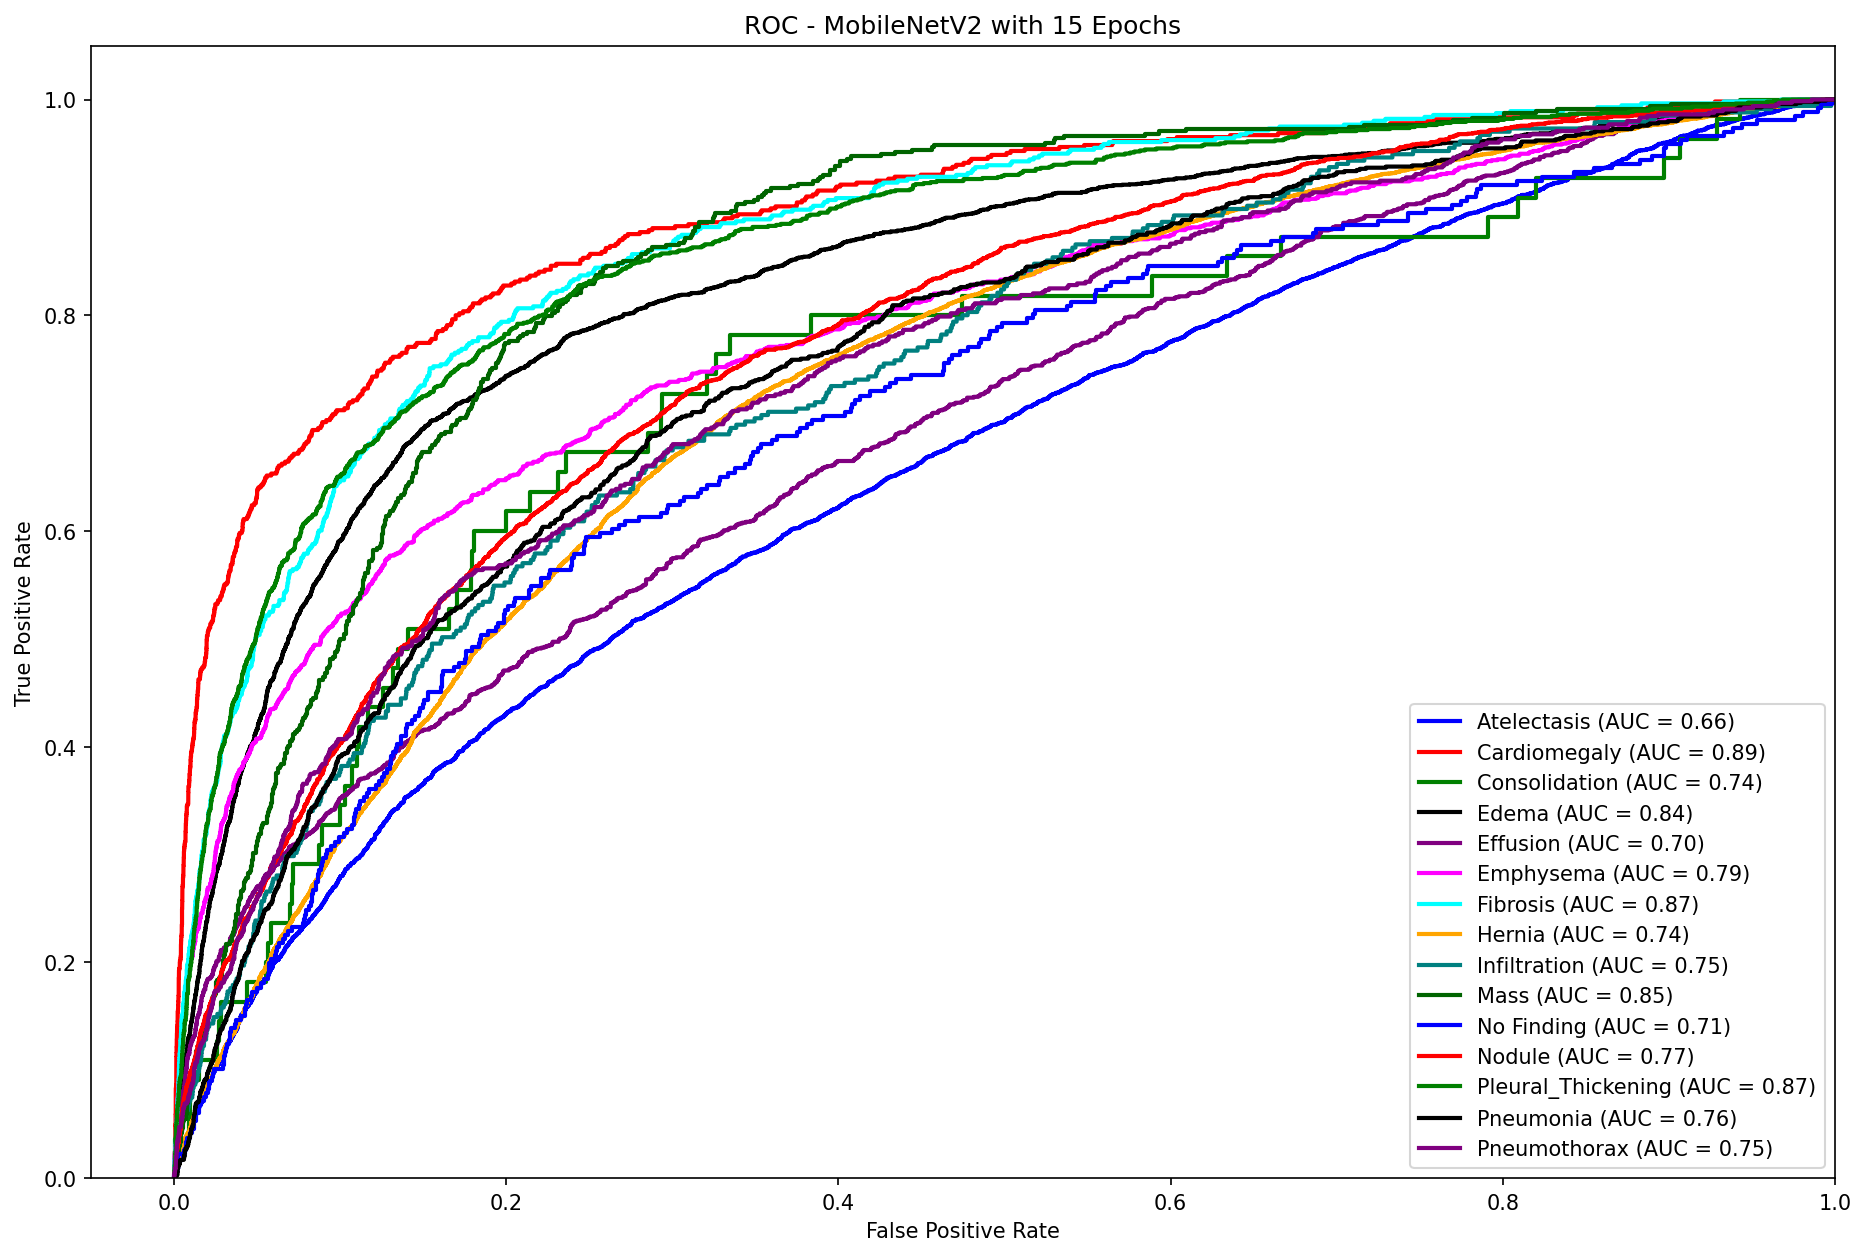

In [35]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.dpi'] = 150

colors = cycle(['blue', 'red', 'green', 'black', 'purple', 'magenta', 'cyan', 'orange', 'teal', 'darkgreen'])
fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2

for i in range(len(CLASS_LABELS)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

avg_auc = 0
for auc_value in roc_auc.values():
    avg_auc += auc_value
print(f"[{MODEL_NAME} with {EPOCHS} Epochs] - Average AUC: {avg_auc / 15}")
    
for i, color in zip(range(len(CLASS_LABELS)), colors):
    plt.plot(fpr[i], tpr[i], color = color, lw = 2, label = '{0} (AUC = {1:0.2f})'''.format(CLASS_LABELS[i], roc_auc[i]))

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC - {MODEL_NAME} with {EPOCHS} Epochs')
plt.legend(loc = "lower right")
plt.show()

In [34]:
avg_auc = 0
for auc_value in roc_auc.values():
    avg_auc += auc_value

print(f"[{MODEL_NAME} with {EPOCHS} Epochs] - Average AUC: {avg_auc / 15}")

[MobileNetV2 with 15 Epochs] - Average AUC: 0.7784512884725044
